In [1]:
# -------------------------------------------------
# IMPORT LIBRARIES
# -------------------------------------------------
# Install Playwright and its browser binaries if not already installed
!pip install playwright
!playwright install

# Install system dependencies required by Playwright
!apt-get update && apt-get install -y libxcomposite1 libgtk-3-0 libatk1.0-0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 MB 21.4 MB/s eta 0:00:00
(node:385) [DEP0169] DeprecationWarning: `url.parse()` behavior is not standardized and prone to errors that have security implications. Use the WHATWG URL API instead. CVEs are not issued for `url.parse()` vulnerabilities.
(Use `node --trace-deprecation ...` to show where the warning was created)
164.7 MiB [] 0% 0.0s164.7 MiB [] 0% 50.9s164.7 MiB [] 0% 19.3s164.7 MiB [] 0% 15.4s164.7 MiB [] 0% 13.9s164.7 MiB [] 1% 6.3s164.7 MiB [] 2% 4.4s164.7 MiB [] 3% 3.7s164.7 MiB [] 3% 3.3s164.7 MiB [] 4% 3.3s164.7 MiB [] 4% 3.2s164.7 MiB [] 6% 2.8s164.7 MiB [] 7% 2.6s164.7 MiB [] 8% 2.4s164.7 MiB [] 8% 2.3s164.7 MiB [] 9% 2.3s164.7 MiB [] 10% 2.3s164.7 MiB [] 11% 2.3s164.7 MiB [] 12% 2.3s164.7 MiB [] 13% 2.2s164.7 MiB [] 14% 2.1s164.7 MiB [] 15% 2.1s164.7 MiB [] 15% 2.2s164.7 MiB [] 16% 2.1s164.7 MiB [] 17% 2.0s164.7 MiB [] 18% 1.9s164.7 MiB [] 19% 1.9s164.7 MiB [] 20% 1.9s164.7 MiB [] 21% 1.8s164.7 MiB [] 22% 1.8s164.

In [2]:
# -------------------------------------------------
# requests:
# Included for completeness and learning purpose.
# (Not used for job scraping here because Remote OK is JS-based)
import requests

# Playwright:
# Used to open a real browser and execute JavaScript.
# This allows us to see jobs that load on scroll.
from playwright.async_api import async_playwright
import asyncio
import nest_asyncio # Added nest_asyncio

# BeautifulSoup:
# Used to parse HTML and extract specific elements easily.
from bs4 import BeautifulSoup

# pandas:
# Used to store data in table form (DataFrame) and save CSV files.
import pandas as pd

# os:
# Used to create folders and handle file paths safely.
import os

# random:
# Used to add random delays so scraping looks human-like.
import random

# datetime:
# Used to add scrape date (optional, useful for tracking).
from datetime import datetime


# -------------------------------------------------
# CONFIGURATION
# -------------------------------------------------

# Base website URL
BASE_URL = "https://remoteok.com"

# Main jobs page (contains all categories of jobs)
JOBS_URL = "https://remoteok.com/remote-jobs"

# Get current file directory
BASE_DIR = os.getcwd()

# Output folder where CSV will be stored
OUTPUT_DIR = os.path.join(BASE_DIR, "data", "raw")

# Final CSV file path
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "remoteok_jobs.csv")


# -------------------------------------------------
# FUNCTION 1: LOAD FULLY RENDERED HTML
# -------------------------------------------------
async def get_rendered_html(target_count=850):
    """
    This function:
    - Opens Remote OK in a browser
    - Scrolls the page multiple times
    - Waits between scrolls (ethical scraping)
    - Stops when enough jobs are loaded
    - Returns the final HTML content
    """

    # Start Playwright
    async with async_playwright() as p:
        print(f"Launching browser. Target: {target_count} jobs.")

        # Launch Chromium browser (headless=True means browser window is hidden)
        browser = await p.chromium.launch(headless=True)

        # Create browser context with realistic screen size
        context = await browser.new_context(
            user_agent=(
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0.0.0 Safari/537.36"
    ),
            viewport={'width': 1920, 'height': 1080}
        )

        # Open a new browser page
        page = await context.new_page()

        try:
            # Open the jobs page
            await page.goto(JOBS_URL, wait_until="load", timeout=90000)

            # Wait so page scripts can initialize
            await page.wait_for_timeout(5000)

            # Track how many jobs were loaded previously
            last_count = 0

            # Count how many times job count does not change
            same_count_rounds = 0

            # Infinite scrolling loop
            while True:
                try:
                    # Scroll down the page
                    # This triggers Remote OK to load more jobs
                    await page.mouse.wheel(0, 5000)

                    # IMPORTANT (Ethical Scraping):
                    # We wait 3–5 seconds after each scroll.
                    # This respects robots.txt crawl-delay
                    # and avoids server overload.
                    await page.wait_for_timeout(random.randint(3000, 5000))

                    # Find all job rows that have real job IDs
                    rows = await page.query_selector_all("tr.job[data-id]")
                    current_count = len(rows)

                    print(f"Jobs found: {current_count}")

                    # Stop if we reached target job count
                    if current_count >= target_count:
                        print("Target reached!")
                        break

                    # If no new jobs loaded, increase counter
                    if current_count == last_count:
                        same_count_rounds += 1
                        # Try keyboard scroll like a human
                        await page.keyboard.press("PageDown")
                    else:
                        same_count_rounds = 0

                    # If page stops loading new jobs, exit loop
                    if same_count_rounds >= 5:
                        print("No more new jobs loading.")
                        break

                    last_count = current_count

                except Exception as inner_e:
                    # Sometimes JS pages flicker – we retry safely
                    print(f"Minor flicker, retrying scroll... ({inner_e})")
                    await page.wait_for_timeout(2000)
                    continue

            # Get final fully rendered HTML
            html_content = await page.content()
            return html_content

        finally:
            # Always close browser to free resources
            await browser.close()


# -------------------------------------------------
# FUNCTION 2: PARSE JOB DATA FROM HTML (UPDATED)
# -------------------------------------------------
def parse_jobs(html):
    """
    This function:
    - Takes rendered HTML
    - Uses BeautifulSoup to extract job details
    - Extracts: job_id, title, company, skills, location, date_posted, url
    """

    soup = BeautifulSoup(html, "html.parser")
    records = []

    # Loop through each real job row
    for row in soup.select("tr.job[data-id]"):
        # Title
        title_tag = row.find("h2", itemprop="title")

        # Company
        company_tag = row.find("h3", itemprop="name")

        # Skills / Tags
        tags = [t.get_text(strip=True) for t in row.select(".tag")]

        # Job URL
        url_suffix = row.get("data-href")

        # Location
        location_tag = row.find("div", class_="location")
        location = location_tag.get_text(strip=True) if location_tag else "Worldwide"

        # Date Posted
        time_tag = row.find("time")
        date_posted = time_tag.get("datetime") if time_tag else "not specified"

        # Append record
        records.append({
            "job_id": row.get("data-id"),
            "title": title_tag.get_text(strip=True) if title_tag else "N/A",
            "company": company_tag.get_text(strip=True) if company_tag else "N/A",
            "skills": ", ".join(tags),
            "location": location,
            "date_posted": date_posted,
            "url": f"https://remoteok.com{url_suffix}" if url_suffix else "N/A"
        })

    return records


# -------------------------------------------------
# MAIN EXECUTION
# -------------------------------------------------
if __name__ == "__main__":
    # Apply nest_asyncio to allow asyncio.run() in a running event loop
    nest_asyncio.apply()

    # Step 1: Load rendered HTML using Playwright
    html = asyncio.run(get_rendered_html(850))

    if html:
        # Step 2: Extract job data from HTML
        data = parse_jobs(html)

        # Step 3: Convert to DataFrame and remove duplicates
        df = pd.DataFrame(data).drop_duplicates(subset=["job_id"])

        # Step 4: Create output folder if it does not exist
        os.makedirs(OUTPUT_DIR, exist_ok=True)

        # Step 5: Save cleaned data to CSV
        df.to_csv(OUTPUT_FILE, index=False)

        print(f"Saved {len(df)} jobs to {OUTPUT_FILE}")

Launching browser. Target: 850 jobs.
Jobs found: 100
Jobs found: 149
Jobs found: 198
Jobs found: 248
Jobs found: 283
Jobs found: 330
Jobs found: 379
Jobs found: 426
Jobs found: 476
Jobs found: 526
Jobs found: 576
Jobs found: 626
Jobs found: 676
Jobs found: 726
Jobs found: 776
Jobs found: 826
Jobs found: 876
Target reached!
Saved 854 jobs to /content/data/raw/remoteok_jobs.csv


In [3]:
# ============================================
# DATA CLEANING – RemoteOK Job Dataset
# Purpose: Clean raw scraped job data and
#          prepare it for analysis & visualization
# ============================================

import pandas as pd

# --------------------------------------------
# Step 1: Load raw scraped dataset
# --------------------------------------------
df = pd.read_csv(OUTPUT_FILE)

# --------------------------------------------
# Step 2: Initial inspection
# --------------------------------------------
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# --------------------------------------------
# Step 3: Remove duplicate records
# --------------------------------------------
df.drop_duplicates(inplace=True)

# --------------------------------------------
# Step 4: Treat invalid placeholders as NaN
# --------------------------------------------
df.replace(["N/A", "n/a", "", "Not specified"], pd.NA, inplace=True)

# Remove whitespace-only values
text_cols = ["title", "company", "skills", "location"]
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].replace(r"^\s*$", pd.NA, regex=True)

# --------------------------------------------
# Step 5: Handle critical missing values
# --------------------------------------------
df.dropna(subset=["title", "company"], inplace=True)

# --------------------------------------------
# Step 6: Handle Skills column
# --------------------------------------------
df["skills"] = df["skills"].fillna("not specified")
df["skills"] = df["skills"].astype(str).str.lower().str.strip()
df["skills"] = df["skills"].str.replace("\n", "", regex=True)

# Convert skills to list
df["Skills_List"] = df["skills"].apply(
    lambda x: [skill.strip() for skill in x.split(",")]
)

# --------------------------------------------
# Step 7: Handle Location (REAL LOGIC)
# --------------------------------------------
df["location"] = df["location"].fillna("Worldwide")
df["location"] = df["location"].astype(str).str.title().str.strip()

# --------------------------------------------
# Step 8: Handle Date Posted (REAL LOGIC)
# --------------------------------------------
df["date_posted"] = pd.to_datetime(
    df["date_posted"], errors="coerce"
)

# --------------------------------------------
# Step 9: Clean title & company formatting
# --------------------------------------------
df["title"] = df["title"].str.title().str.strip()
df["company"] = df["company"].str.title().str.strip()

# --------------------------------------------
# Step 10: Final validation
# --------------------------------------------
print("\nFinal Dataset Info After Cleaning:")
print(df.info())

print("\nFinal Missing Values:")
print(df.isnull().sum())

# --------------------------------------------
# Step 11: Save cleaned dataset
# --------------------------------------------
df.to_csv("remoteok_jobs_cleaned.csv", index=False)

print("\n Data cleaning completed successfully!")
print(" Cleaned file saved as 'remoteok_jobs_cleaned.csv'")


Dataset Shape: (854, 7)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854 entries, 0 to 853
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   job_id       854 non-null    int64 
 1   title        854 non-null    object
 2   company      854 non-null    object
 3   skills       833 non-null    object
 4   location     854 non-null    object
 5   date_posted  854 non-null    object
 6   url          854 non-null    object
dtypes: int64(1), object(6)
memory usage: 46.8+ KB
None

Missing Values:
job_id          0
title           0
company         0
skills         21
location        0
date_posted     0
url             0
dtype: int64

Final Dataset Info After Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854 entries, 0 to 853
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   job_id       854 non-nu

Dataset Shape: (854, 8)

Columns: Index(['job_id', 'title', 'company', 'skills', 'location', 'date_posted',
       'url', 'Skills_List'],
      dtype='object')

Sample Data:
    job_id                                              title  \
0  1129763                $1K Weekly Work From Home Assistant   
1  1129395                     Coding Bootcamp﹣Job Guaranteed   
2  1129874                    Staff Site Reliability Engineer   
3  1129873  Senior Social Media & Digital Marketing Virtua...   
4  1129872                       Technical Support Specialist   

             company                                             skills  \
0  Best Estimate Pro  sales, marketing, admin, customer support, vir...   
1             Metana  no tech background needed, job or 100% money back   
2          Achievers  design, security, architect, technical, suppor...   
3       Assist World  assistant, training, support, growth, video, a...   
4      Robin Powered  technical, support, edu, operations, h

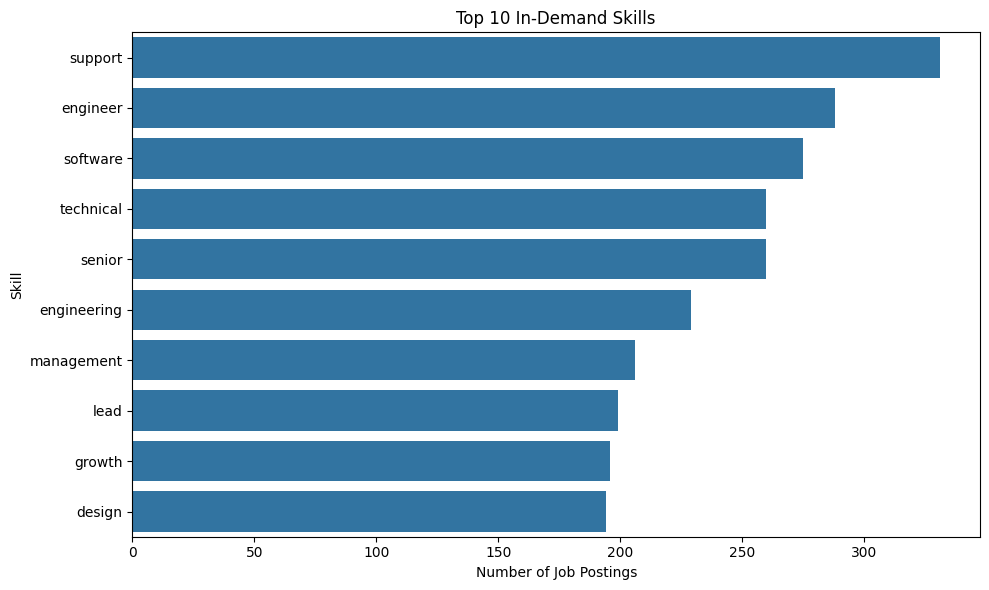


Job Type Distribution:
Job_Type
Other          351
Engineering    297
Management     129
Data            45
Design          32
Name: count, dtype: int64


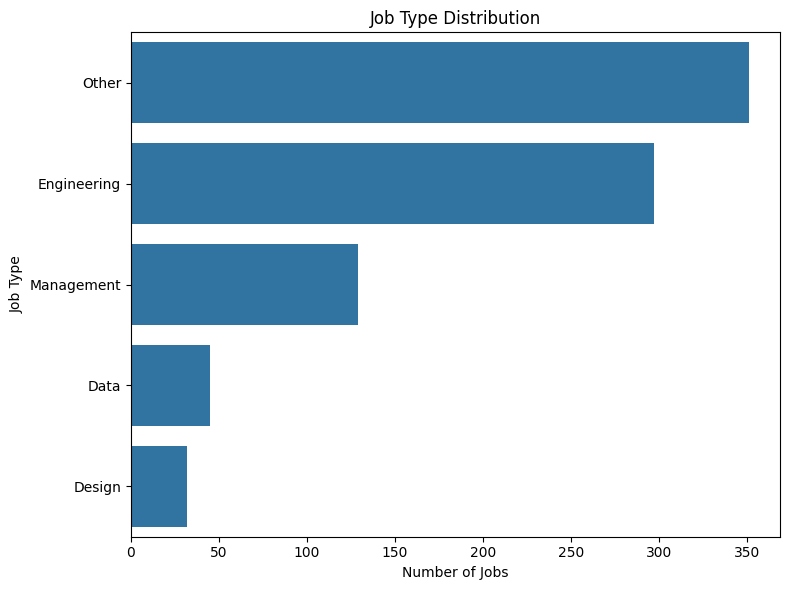


Top 10 Job Titles:
title
Software Engineer           12
Senior Software Engineer    12
Current Openings            10
Account Manager              6
Product Manager              5
Senior Data Engineer         5
Customer Success Manager     5
Account Executive            5
Growth Marketing Manager     4
Staff Software Engineer      4
Name: count, dtype: int64


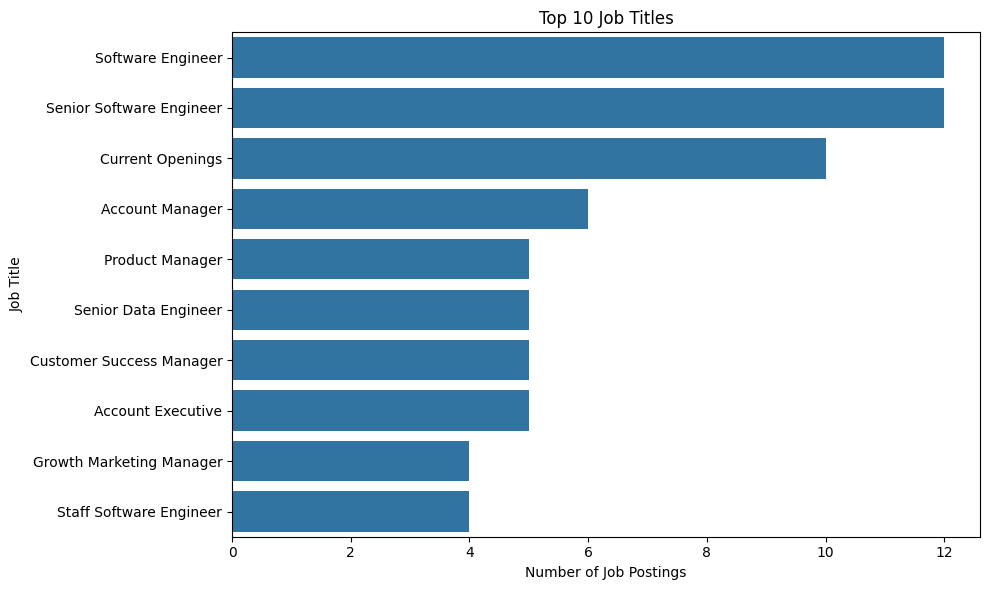


Top Hiring Locations:
location_cleaned
Worldwide                 186
Unknown                   166
Remote                     92
United States              56
San Francisco              22
United States (Remote)     20
New York                   17
India                      10
Texas                      10
Canada                      8
Name: count, dtype: int64


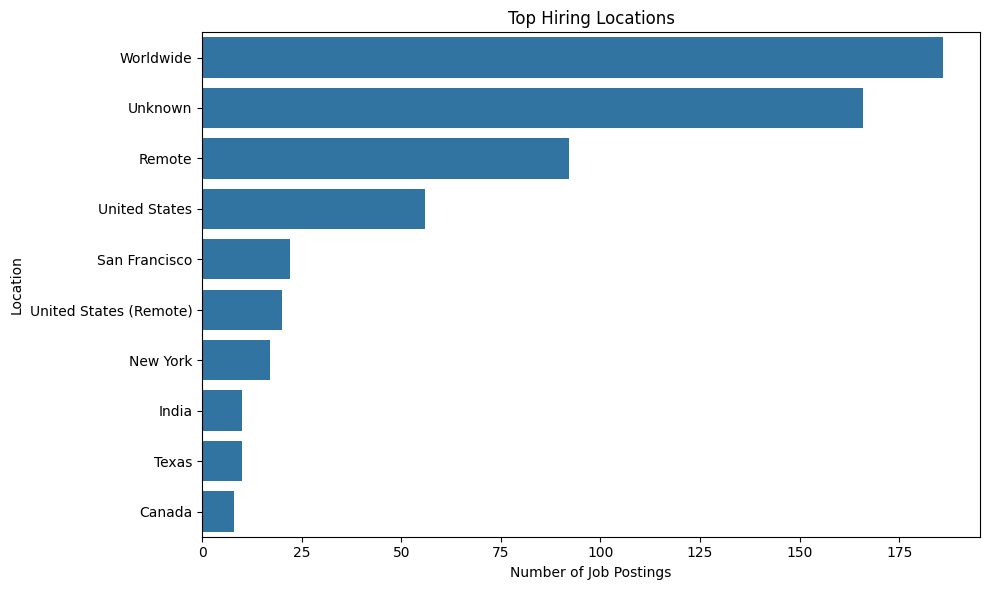


Jobs Posted Over Time (Monthly Trend):
date_posted
2025-11-30 00:00:00+00:00    196
2025-12-31 00:00:00+00:00    252
2026-01-31 00:00:00+00:00    406
Freq: ME, dtype: int64


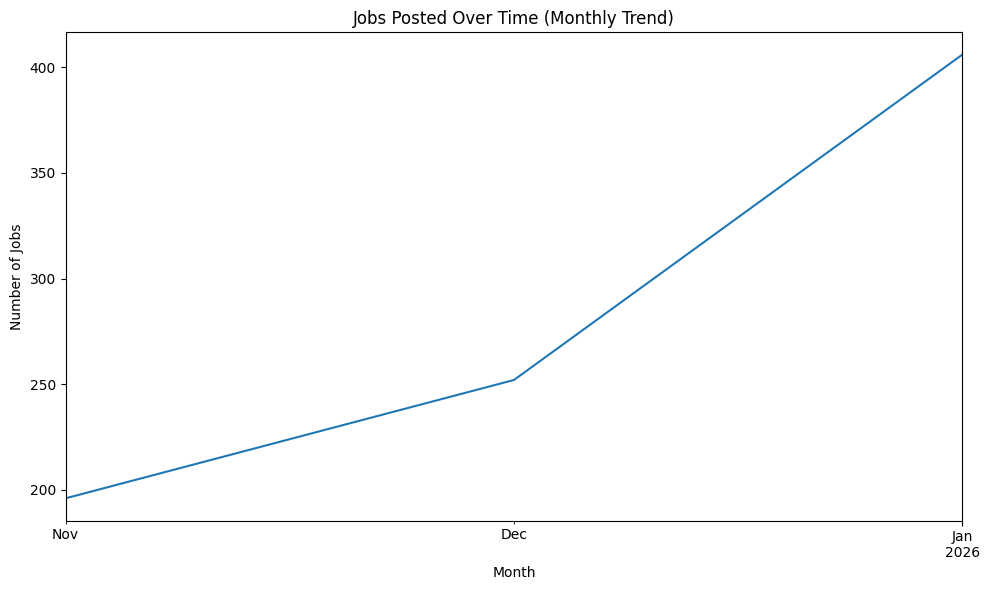


Skill Category Comparison:
         Skill Category  Count
0      Technical Skills     97
1  Non-Technical Skills   6875


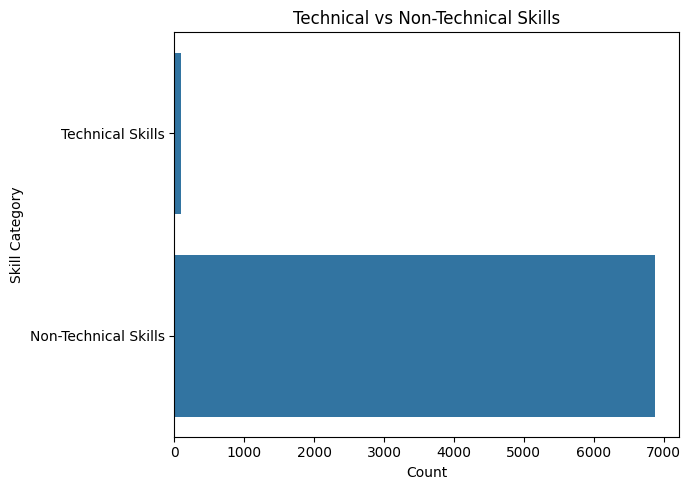

EDA & visualizations generated successfully!


In [5]:
# ==========================================================
# EDA & VISUALIZATION – RemoteOK Cleaned Dataset
# Purpose:
#   - Perform Exploratory Data Analysis
#   - Identify trends in jobs, skills, companies
#   - Generate required visualizations
#   - Save plots as PNG files
# ==========================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

# ----------------------------------------------------------
# Step 1: Load cleaned dataset
# ----------------------------------------------------------
df = pd.read_csv("remoteok_jobs_cleaned.csv")

# Convert date_posted to datetime
df["date_posted"] = pd.to_datetime(df["date_posted"], errors="coerce")

# ----------------------------------------------------------
# Step 2: Create visualizations folder
# ----------------------------------------------------------
output_dir = "visualizations"
os.makedirs(output_dir, exist_ok=True)

# ----------------------------------------------------------
# Step 3: Dataset overview
# ----------------------------------------------------------
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns)
print("\nSample Data:")
print(df.head())

# ----------------------------------------------------------
# Step 4: CLEAN LOCATION (REMOVE EMOJIS & NOISE)
# ----------------------------------------------------------
def clean_location(loc):
    if pd.isna(loc):
        return "Unknown"

    # Remove emojis and non-ASCII symbols
    loc = re.sub(r'[^\x00-\x7F]+', '', loc)
    loc = loc.strip().lower()

    if "upgrade to premium" in loc:
        return "Unknown"
    if "probably worldwide" in loc or "worldwide" in loc:
        return "Worldwide"
    if "remote" in loc and "united states" in loc:
        return "United States (Remote)"
    if "remote" in loc:
        return "Remote"

    return loc.title()

df["location_cleaned"] = df["location"].apply(clean_location)
# ----------------------------------------------------------
# Step 5: Prepare Skills List
# ----------------------------------------------------------
df["Skills_List"] = df["Skills_List"].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)

all_skills = []
for skills in df["Skills_List"]:
    all_skills.extend(skills)

all_skills = [skill for skill in all_skills if skill != "not specified"]

# ==========================================================
# EDA 1: Top Skills
# ==========================================================
top_skills = pd.Series(all_skills).value_counts().head(10)

print("\nTop 10 Job Skills:")
print(top_skills)

#Visualization: Top Skills
plt.figure(figsize=(10, 6))
sns.barplot(x=top_skills.values, y=top_skills.index)
plt.title("Top 10 In-Demand Skills")
plt.xlabel("Number of Job Postings")
plt.ylabel("Skill")
plt.tight_layout()
plt.savefig(f"{output_dir}/top_skills.png")
plt.show()

# ==========================================================
# EDA 2: Job Type Distribution
# ==========================================================
def classify_job_type(title):
    title = title.lower()
    if "data" in title:
        return "Data"
    elif "engineer" in title or "developer" in title:
        return "Engineering"
    elif "designer" in title:
        return "Design"
    elif "manager" in title:
        return "Management"
    else:
        return "Other"

df["Job_Type"] = df["title"].apply(classify_job_type)

job_type_counts = df["Job_Type"].value_counts()

print("\nJob Type Distribution:")
print(job_type_counts)

# Visualization: Job Type Distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=job_type_counts.values, y=job_type_counts.index)
plt.title("Job Type Distribution")
plt.xlabel("Number of Jobs")
plt.ylabel("Job Type")
plt.tight_layout()
plt.savefig(f"{output_dir}/job_type_distribution.png")
plt.show()

# ==========================================================
# EDA 3: Top Job Titles
# ==========================================================
top_job_titles = df["title"].value_counts().head(10)

print("\nTop 10 Job Titles:")
print(top_job_titles)

#VISUALIZATION: Top Job Titles
plt.figure(figsize=(10, 6))
sns.barplot(x=top_job_titles.values, y=top_job_titles.index)
plt.title("Top 10 Job Titles")
plt.xlabel("Number of Job Postings")
plt.ylabel("Job Title")
plt.tight_layout()
plt.savefig(f"{output_dir}/top_job_titles.png")
plt.show()

# ==========================================================
# EDA 4: Location Analysis
# ==========================================================
top_locations = df["location_cleaned"].value_counts().head(10)

print("\nTop Hiring Locations:")
print(top_locations)

# VISUALIZATION: Top Hiring Locations
plt.figure(figsize=(10, 6))
sns.barplot(x=top_locations.values, y=top_locations.index)
plt.title("Top Hiring Locations")
plt.xlabel("Number of Job Postings")
plt.ylabel("Location")
plt.tight_layout()
plt.savefig(f"{output_dir}/top_locations.png")
plt.show()

# ==========================================================
# EDA 5: Jobs Posted Over Time
# ==========================================================
jobs_by_month = (
    df.dropna(subset=["date_posted"])
      .set_index("date_posted")
      .resample("ME")
      .size()
)

print("\nJobs Posted Over Time (Monthly Trend):")
print(jobs_by_month)

# VISUALIZATION: Jobs Posted Over Time
plt.figure(figsize=(10, 6))
jobs_by_month.plot()
plt.title("Jobs Posted Over Time (Monthly Trend)")
plt.xlabel("Month")
plt.ylabel("Number of Jobs")
plt.tight_layout()
plt.savefig(f"{output_dir}/jobs_posted_over_time.png")
plt.show()

# ==========================================================
# EDA 6: Skill Category Comparison
# ==========================================================
technical_skills = {
    "python","java","sql","javascript","react","aws","docker",
    "kubernetes","machine learning","data science","power bi","tableau"
}

technical_count = 0
non_technical_count = 0

for skill in all_skills:
    if skill.lower() in technical_skills:
        technical_count += 1
    else:
        non_technical_count += 1

skill_df = pd.DataFrame({
    "Skill Category": ["Technical Skills", "Non-Technical Skills"],
    "Count": [technical_count, non_technical_count]
})

print("\nSkill Category Comparison:")
print(skill_df)

# VISUALIZATION: Skill Category Comparison
plt.figure(figsize=(7, 5))
sns.barplot(x="Count", y="Skill Category", data=skill_df)
plt.title("Technical vs Non-Technical Skills")
plt.tight_layout()
plt.savefig(f"{output_dir}/skill_category_comparison.png")
plt.show()

# ----------------------------------------------------------
# Final confirmation
# ----------------------------------------------------------
print("EDA & visualizations generated successfully!")
